## First pass of project

In [104]:
# Imports
import pandas as pd
import numpy as np
import os
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Bidirectional
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [105]:
#function to plot the prediction
def plot_prediction(n_steps, naive_prediction, y_test, y_pred):
    plt.clf()
    plt.plot(range(n_steps), y_test, c='blue', label="y_test")
    plt.plot(range(n_steps), y_pred, c='red', label="y_pred") # remember to inverse the transform
    plt.plot(range(n_steps), naive_prediction, c='green', label="naive")
    plt.legend(loc="upper left")
    plt.show()

In [106]:
# Load Preprocessed Data
cwd = os.getcwd()
formatted_bitcoin_tweets_file = os.getcwd() + "\\Data\\formatted_bitcoin_tweets_labelled.csv"
formatted_bitcoin_price_file = os.getcwd() + "\\Data\\formatted_bitcoin_price.csv"
df_price = pd.read_csv(formatted_bitcoin_price_file)
df_price = df_price.set_index(pd.DatetimeIndex(df_price['date'])) #Moving time data into index
df_price.drop(['date'], inplace=True, axis=1)

df_tweets = pd.read_csv(formatted_bitcoin_tweets_file)
df_tweets = df_tweets.set_index(pd.DatetimeIndex(df_tweets['date'])) #Moving time data into index
df_tweets = df_tweets[['sentiment']]

print("price_df")
print(df_price.shape)
print(df_price.head())

print("tweets_df")
print(df_tweets.shape)
print(df_tweets.head())

price_df
(386, 3)
                    open         close  target
date                                          
2021-02-10  46469.761719  44918.183594       0
2021-02-11  44898.710938  47909.332031       1
2021-02-12  47877.035156  47504.851563       0
2021-02-13  47491.203125  47105.515625       0
2021-02-14  47114.507813  48717.289063       1
tweets_df
(1148241, 1)
            sentiment
date                 
2021-02-10          0
2021-02-10          0
2021-02-10          1
2021-02-10          1
2021-02-10          1


In [107]:
df_tweets.head()

,sentiment
date,
2021-02-10,0
2021-02-10,0
2021-02-10,1
2021-02-10,1
2021-02-10,1


<AxesSubplot:xlabel='date'>

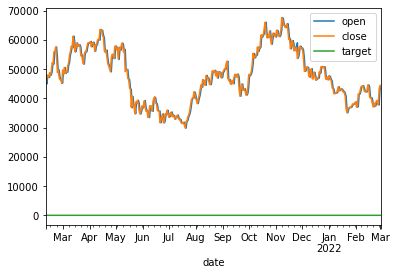

In [108]:
df_price.plot()

<AxesSubplot:xlabel='date'>

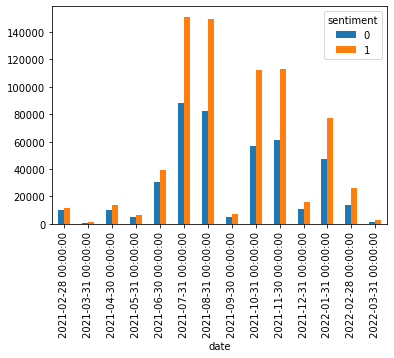

In [109]:
df_tweets['sentiment'].groupby(pd.Grouper(freq="M")).value_counts().unstack().plot(kind="bar")

##### Rollup sentiment by day (mode)

In [110]:
# def numpy_mode(series):
#     values = series.values
#     dropped = values[~np.isnan(values)]

#     # check for empty array and return NaN
#     if not dropped.size:
#         return np.NaN

#     uniques, counts = np.unique(series.dropna(), return_counts=True)
#     return uniques[np.argmax(counts)]

# df_tweets = df_tweets.resample('D').apply(lambda x: x.apply(numpy_mode))
# print(df_tweets.head())

##### Rollup sentiment by day (scaled)

In [111]:
def numpy_scaled(series):
    num_0 = np.sum(series.values == 0)
    num_1 = np.sum(series.values == 1)
    max_val = max(num_0, num_1)
    if max_val == 0:    # So we don't divide by 0
        return 0
    return (num_1-num_0) / max_val

df_tweets = df_tweets.resample('D').apply(numpy_scaled)
df_tweets.head()

,sentiment
date,
2021-02-05,0.181395
2021-02-06,0.164090
2021-02-07,0.083223
2021-02-08,0.463641
2021-02-09,0.358913


##### Merge Dataframes

In [112]:
df_price = df_price.merge(df_tweets, on='date', how='left')
df_price.head()

,open,close,target,sentiment
date,,,,
2021-02-10,46469.761719,44918.183594,0,0.255274
2021-02-11,44898.710938,47909.332031,1,0.000000
2021-02-12,47877.035156,47504.851563,0,0.000000
2021-02-13,47491.203125,47105.515625,0,0.300935
2021-02-14,47114.507813,48717.289063,1,-0.006363


##### Check Correlation between target and sentiment.

In [113]:
from scipy.stats import pearsonr, pointbiserialr, spearmanr, kendalltau

# Typical correlation measurements may not be good measurements since we are dealing with binary + continuious mix.
# Point-Biserial Correlation is required.  

data = df_price[['target','sentiment']]

print(pearsonr(data['target'], data['sentiment']))
print(spearmanr(data['target'], data['sentiment']))
print(kendalltau(data['target'], data['sentiment']))
print(pointbiserialr(data['target'], data['sentiment']))

print("-------------- Shifted ---")
data['target'] = np.roll(data['target'], 1)

print(pearsonr(data['target'], data['sentiment']))
print(spearmanr(data['target'], data['sentiment']))
print(kendalltau(data['target'], data['sentiment']))
print(pointbiserialr(data['target'], data['sentiment']))


(0.043065453712821875, 0.3988094752167505)
SpearmanrResult(correlation=0.016790806528958764, pvalue=0.7422763941986217)
KendalltauResult(correlation=0.01562152271005176, pvalue=0.7418084656745717)
PointbiserialrResult(correlation=0.043065453712821875, pvalue=0.3988094752167505)
-------------- Shifted ---
(0.029455582435296397, 0.5639673434097887)
SpearmanrResult(correlation=0.02802347779443204, pvalue=0.5830766974186851)
KendalltauResult(correlation=0.02607196944502573, pvalue=0.582415168359463)
PointbiserialrResult(correlation=0.029455582435296397, pvalue=0.5639673434097887)


C:\Users\jmarcoglie\AppData\Local\Temp\ipykernel_14464\489101052.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = np.roll(data['target'], 1)


##### Remove extra fields

In [114]:
df_price.drop('target', axis=1, inplace=True)
df_price.drop('open', axis=1, inplace=True)
df_price.head()

,close,sentiment
date,,
2021-02-10,44918.183594,0.255274
2021-02-11,47909.332031,0.000000
2021-02-12,47504.851563,0.000000
2021-02-13,47105.515625,0.300935
2021-02-14,48717.289063,-0.006363


In [115]:
df_price.describe()

,close,sentiment
count,386.000000,386.000000
mean,47638.951314,0.105700
std,9101.025856,0.191723
min,29807.347656,-0.377465
25%,40146.236328,0.000000
50%,47251.761719,0.000000
75%,55967.820313,0.183714
max,67566.828125,0.671545


# Hyperparameter tuning 

In [ ]:
def build_LSTM(n_steps, neurons, opt):
    model = Sequential()
    model.add(LSTM(neurons, activation='relu', input_shape=(n_steps, 1)))
    model.add(Dense(1))
    model.compile(optimizer=opt, loss='mse', metrics=['mse'])
    return model

import itertools
def model_configs():
	# define scope of configs
	neurons = range(10, 50, 10)
	opt = ['adam','sgd','rmsprop','ftrl']
	epochs = [10, 20, 30, 40, 50]
	prediction_horizon = [5, 10, 30, 60, 90]
	lookback_window = [25, 50, 75, 100]
	a = [neurons, opt, epochs, prediction_horizon, lookback_window]
	# create configs
	configs = list(itertools.product(*a))
	print('Total configs: %d' % len(configs))
	return configs

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Embedding, Bidirectional
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

output_dic = {'Combination': [], 'RMSE': [], 'Predictions': []}

cfg_list = model_configs()
counter = 0
for config in cfg_list:
	counter = counter+1
	print("running" + str(counter))
	prediction_horizon = config[3] # i.e. predict last week's values
	n_steps = config[4] # look back window reducing dues to high computitional cost
	n_features = 1 # of features in the data

	# LSTM input is of the form (n_samples, n_steps, n_features)
	X_train = df_price["close"].values[:-prediction_horizon] 
	X_test = df_price["close"].values[-(n_steps + prediction_horizon):]
	y_test = df_price["close"].values[-prediction_horizon:]

	naive_prediction = df_price["close"].values[-(prediction_horizon+prediction_horizon):-prediction_horizon]

	scaler = StandardScaler()
	scaler.fit(X_train.reshape(-1, 1))
	scaled_X_train = scaler.transform(X_train.reshape(-1, 1))
	scaled_X_test = scaler.transform(X_test.reshape(-1, 1))
	scaled_y_test = scaler.transform(y_test.reshape(-1, 1))

	# Convert  the data from sequence to supervised data - [2, 3, 4, 5, 4, 6, 7] = [2, 3, 4] -> [5]
	train_generator = TimeseriesGenerator(scaled_X_train, scaled_X_train, length=n_steps, batch_size=prediction_horizon)  # batch size?   
	test_generator = TimeseriesGenerator(scaled_X_test, scaled_X_test, length=n_steps, batch_size=prediction_horizon)
	
	model = build_LSTM(n_steps, config[0], config[1])
	history = model.fit(train_generator, epochs=config[2], verbose=0)
	prediction = model.predict(test_generator)
	y_pred = scaler.inverse_transform(prediction)

	y_pred = np.nan_to_num(y_pred)
	RMSE = mean_squared_error(y_test, y_pred, squared=False)
	output_dic['Combination'].append(config)
	output_dic['RMSE'].append(RMSE)
	output_dic['Predictions'].append(y_pred)

#### Uncomment the below to run specific parameters

In [180]:
# def build_LSTM(n_steps, neurons, opt):
#     model = Sequential()
#     model.add(LSTM(neurons, activation='relu', input_shape=(n_steps, 1)))
#     model.add(Dense(1))
#     model.compile(optimizer=opt, loss='mse', metrics=['mse'])
#     return model

# import itertools
# def model_configs():
# 	configs = [[10, 'adam', 80, 90, 50],[20, 'rmsprop', 90, 90, 25], [40, 'adam', 90, 90, 25]] # 90 day horizon
# 	#configs = [[40, 'adam', 50, 30, 25],[20, 'adam', 50, 30, 25], [30, 'adam', 50, 30, 25]] # 30 day horizon
# 	print('Total configs: %d' % len(configs))
# 	return configs

# import matplotlib.pyplot as plt
# import pandas as pd
# import numpy as np
# from keras.models import Sequential
# from keras.layers import Dense, LSTM, GRU, Embedding, Bidirectional
# from keras.preprocessing.sequence import TimeseriesGenerator
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import GridSearchCV

# output_dic = {'Combination': [], 'RMSE': [], 'Predictions': []}

# cfg_list = model_configs()
# counter = 0
# for config in cfg_list:
# 	counter = counter+1
# 	print("running" + str(counter))
# 	prediction_horizon = config[3] # i.e. predict last week's values
# 	n_steps = config[4] # look back window reducing dues to high computitional cost
# 	n_features = 1 # of features in the data

# 	# LSTM input is of the form (n_samples, n_steps, n_features)
# 	X_train = df_price["close"].values[:-prediction_horizon] 
# 	X_test = df_price["close"].values[-(n_steps + prediction_horizon):]
# 	y_test = df_price["close"].values[-prediction_horizon:]

# 	naive_prediction = df_price["close"].values[-(prediction_horizon+prediction_horizon):-prediction_horizon]

# 	scaler = StandardScaler()
# 	scaler.fit(X_train.reshape(-1, 1))
# 	scaled_X_train = scaler.transform(X_train.reshape(-1, 1))
# 	scaled_X_test = scaler.transform(X_test.reshape(-1, 1))
# 	scaled_y_test = scaler.transform(y_test.reshape(-1, 1))

# 	# Convert  the data from sequence to supervised data - [2, 3, 4, 5, 4, 6, 7] = [2, 3, 4] -> [5]
# 	train_generator = TimeseriesGenerator(scaled_X_train, scaled_X_train, length=n_steps, batch_size=prediction_horizon)  # batch size?   
# 	test_generator = TimeseriesGenerator(scaled_X_test, scaled_X_test, length=n_steps, batch_size=prediction_horizon)
	
# 	model = build_LSTM(n_steps, config[0], config[1])
# 	history = model.fit(train_generator, epochs=config[2], verbose=0)
# 	prediction = model.predict(test_generator)
# 	y_pred = scaler.inverse_transform(prediction)

# 	y_pred = np.nan_to_num(y_pred)
# 	RMSE = mean_squared_error(y_test, y_pred, squared=False)
# 	output_dic['Combination'].append(config)
# 	output_dic['RMSE'].append(RMSE)
# 	output_dic['Predictions'].append(y_pred)

Total configs: 3
running1
running2
running3


In [181]:
output_df = pd.DataFrame(output_dic)
output_df_sorted = output_df.sort_values(by='RMSE', ascending=True)
pred = output_df_sorted['Predictions'].iloc[:3]
rmse = output_df_sorted['RMSE'].iloc[:3]
labels = output_df_sorted['Combination'].iloc[:3]
labels

2       [40, adam, 90, 90, 25]
1    [20, rmsprop, 90, 90, 25]
0       [10, adam, 80, 90, 50]
Name: Combination, dtype: object

In [182]:
rmse

2    1897.219474
1    1924.931883
0    2373.396609
Name: RMSE, dtype: float64

<Figure size 432x288 with 0 Axes>

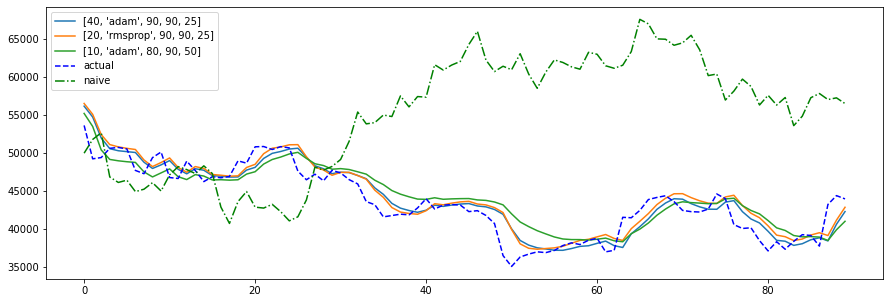

In [183]:
prediction_horizon = 90
plt.clf()    
plt.figure(figsize=(15, 5))

for y_pred, label in zip(pred, labels):
    plt.plot(range(prediction_horizon), y_pred.flatten(), label=label) # remember to inverse the transform

plt.plot(range(prediction_horizon), y_test, c='blue', label="actual", linestyle = 'dashed')
plt.plot(range(prediction_horizon), naive_prediction, c='green', label="naive",  linestyle = 'dashdot')
plt.legend(loc="upper left")
plt.show()

## Phase 1: Create Neural Net to predict close. Compare to naive baseline. 

In [184]:
def Calc_MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [ ]:
import math
def build_LSTM(lookback_window, neurons, opt):
    model = Sequential()
    model.add(LSTM(neurons, activation='relu', input_shape=(lookback_window, 1)))
    model.add(Dense(1))
    model.compile(optimizer=opt, loss='mse', metrics=['mse'])
    return model

def build_LSTM_stacked(lookback_window, neurons, opt):
    model = Sequential()
    model.add(LSTM(neurons, activation='relu', return_sequences = True, input_shape=(lookback_window, 1)))
    model.add(LSTM(math.floor(neurons/2)))
    model.add(Dense(1))
    model.compile(optimizer=opt, loss='mse', metrics=['mse'])
    return model

def build_LSTM_bidirectional(lookback_window, neurons, opt): 
    model = Sequential()
    model.add(Bidirectional(LSTM(neurons, activation='relu', return_sequences = True, input_shape=(lookback_window, 1))))
    model.add(Bidirectional(LSTM(math.floor(neurons/2))))
    model.add(Dense(1))
    model.compile(optimizer=opt, loss='mse', metrics=['mse'])
    return model

def build_GRU(lookback_window, neurons, opt):
    model = Sequential()
    model.add(GRU(neurons, activation='relu', input_shape=(lookback_window, 1)))
    model.add(Dense(1))
    model.compile(optimizer=opt, loss='mse', metrics=['mse'])
    return model

def build_GRU_stacked(lookback_window, neurons, opt):
    model = Sequential()
    model.add(GRU(neurons, activation='relu', return_sequences = True, input_shape=(lookback_window, 1)))
    model.add(GRU(math.floor(neurons/2)))
    model.add(Dense(1))
    model.compile(optimizer=opt, loss='mse', metrics=['mse'])
    return model

def build_GRU_bidirectional(lookback_window, neurons, opt):
    model = Sequential()
    model.add(Bidirectional(GRU(neurons, activation='relu', return_sequences = True, input_shape=(lookback_window, 1))))
    model.add(Bidirectional(GRU(math.floor(neurons/2))))
    model.add(Dense(1))
    model.compile(optimizer=opt, loss='mse', metrics=['mse'])
    return model

### Best hyperparameters against all models

In [204]:
# Grab best hyperparameter combination from tuning run
n_top = 0
neurons = int(output_df_sorted.iloc[n_top][0][0])
opt = str(output_df_sorted.iloc[n_top][0][1])
epochs = int(output_df_sorted.iloc[n_top][0][2])
prediction_horizon = int(output_df_sorted.iloc[n_top][0][3])
lookback_window = int(output_df_sorted.iloc[n_top][0][4])

output_df_sorted.iloc[n_top][0]

(40, 'adam', 50, 90, 25)

In [187]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Embedding, Bidirectional
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

n_features = 1 # of features in the data

# LSTM input is of the form (n_samples, lookback_window, n_features)
X_train = df_price["close"].values[:-prediction_horizon] 
X_test = df_price["close"].values[-(lookback_window + prediction_horizon):]
y_test = df_price["close"].values[-prediction_horizon:]

naive_prediction = df_price["close"].values[-(prediction_horizon+prediction_horizon):-prediction_horizon]

scaler = StandardScaler()
scaler.fit(X_train.reshape(-1, 1))
scaled_X_train = scaler.transform(X_train.reshape(-1, 1))
scaled_X_test = scaler.transform(X_test.reshape(-1, 1))
scaled_y_test = scaler.transform(y_test.reshape(-1, 1))

# Convert  the data from sequence to supervised data - [2, 3, 4, 5, 4, 6, 7] = [2, 3, 4] -> [5]
train_generator = TimeseriesGenerator(scaled_X_train, scaled_X_train, length=lookback_window, batch_size=prediction_horizon)  
test_generator = TimeseriesGenerator(scaled_X_test, scaled_X_test, length=lookback_window, batch_size=prediction_horizon)

list_of_models = ['build_LSTM', 'build_LSTM_stacked', 'build_LSTM_bidirectional', 'build_GRU', 'build_GRU_stacked', 'build_GRU_bidirectional']

output_df = {'Models': [], 'MSE':[], 'RMSE': [], 'MAPE': []}

for m in list_of_models:
    model = globals()[m](lookback_window, neurons, opt)
    history = model.fit(train_generator, epochs=epochs, verbose=0)
    prediction = model.predict(test_generator)
    y_pred = scaler.inverse_transform(prediction)

    MSE = mean_squared_error(y_test, y_pred, squared=True)
    RMSE = mean_squared_error(y_test, y_pred, squared=False)
    MAPE = Calc_MAPE(y_test, y_pred)
    output_df['Models'].append(m)
    output_df['MSE'].append(MSE)
    output_df['RMSE'].append(RMSE)
    output_df['MAPE'].append(MAPE)
    
naive_baseline_MSE = mean_squared_error(y_test, naive_prediction, squared=True)
naive_baseline_RMSE = mean_squared_error(y_test, naive_prediction, squared=False)
naive_baseline_MAPE = Calc_MAPE(y_test, y_pred)
output_df['Models'].append('naive_baseline')
output_df['MSE'].append(naive_baseline_MSE)
output_df['RMSE'].append(naive_baseline_RMSE)
output_df['MAPE'].append(naive_baseline_MAPE)

pd.DataFrame(output_df)

,Models,MSE,RMSE,MAPE
0,build_LSTM,4.322378e+06,2079.032983,12.124374
1,build_LSTM_stacked,7.417760e+06,2723.556534,12.822548
2,build_LSTM_bidirectional,6.447592e+06,2539.210996,12.021906
3,build_GRU,2.448763e+06,1564.852434,12.136807
4,build_GRU_stacked,2.591019e+06,1609.664222,12.346874
5,build_GRU_bidirectional,2.988129e+06,1728.620579,12.400062
6,naive_baseline,2.601689e+08,16129.753089,12.400062


In [188]:
pd.DataFrame(output_df).sort_values(['MSE'], ascending=True)

,Models,MSE,RMSE,MAPE
3,build_GRU,2.448763e+06,1564.852434,12.136807
4,build_GRU_stacked,2.591019e+06,1609.664222,12.346874
5,build_GRU_bidirectional,2.988129e+06,1728.620579,12.400062
0,build_LSTM,4.322378e+06,2079.032983,12.124374
2,build_LSTM_bidirectional,6.447592e+06,2539.210996,12.021906
1,build_LSTM_stacked,7.417760e+06,2723.556534,12.822548
6,naive_baseline,2.601689e+08,16129.753089,12.400062


dict_keys(['loss', 'mse'])


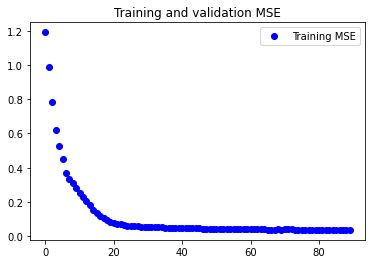

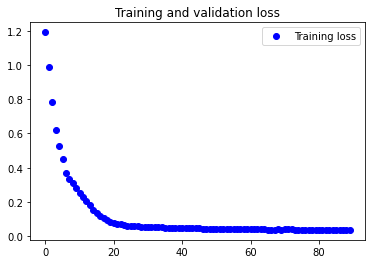

In [189]:
print(history.history.keys())
mse = history.history['mse']
#val_acc = history.history['val_accuracy']
loss = history.history['loss']
#val_loss = history.history['val_loss']
 
plt.plot(range(epochs), mse, 'bo', label='Training MSE')
#plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation MSE')
plt.legend()
 
plt.figure()
 
plt.plot(range(epochs), loss, 'bo', label='Training loss')
#plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

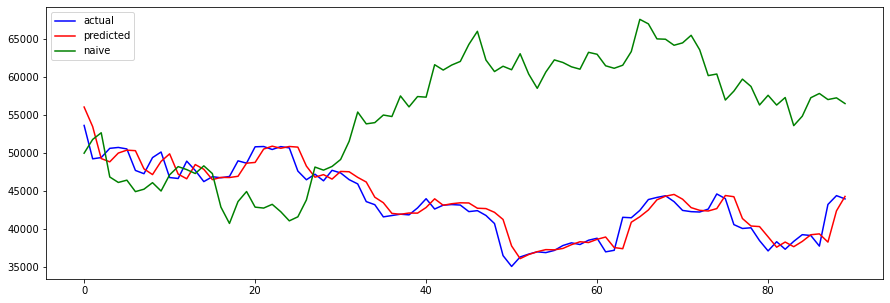

In [190]:
model = build_GRU(lookback_window, neurons, opt)

history = model.fit(train_generator, epochs=epochs, verbose=0)
prediction = model.predict(test_generator)
y_pred = scaler.inverse_transform(prediction)
y_pred = y_pred.flatten()

plt.clf()
plt.figure(figsize=(15, 5))
plt.plot(range(prediction_horizon), y_test, c='blue', label="actual")
plt.plot(range(prediction_horizon), y_pred, c='red', label="predicted") # remember to inverse the transform
plt.plot(range(prediction_horizon), naive_prediction, c='green', label="naive")
plt.legend(loc="upper left")
plt.show()

## Phase 2: Create Neural Net to predict target which also uses sentiment tweets. Compare to naive baseline and phase 1 predictions as baseline. 

##### Roll close value forward

In [191]:
df_price['close'] = np.roll(df_price['close'], 1)
df_price.tail()

,close,sentiment
date,,
2022-02-26,39214.218750,0.000000
2022-02-27,39105.148438,0.000000
2022-02-28,37709.785156,0.000000
2022-03-01,43193.234375,0.000000
2022-03-02,44354.636719,0.586122


In [192]:
def build_LSTM_sentiment(lookback_window, neurons, opt):
    model = Sequential()
    model.add(LSTM(neurons, activation='relu', input_shape=(lookback_window, 2)))
    model.add(Dense(1))
    model.compile(optimizer=opt, loss='mse', metrics=['mse'])
    return model

def build_LSTM_stacked_sentiment(lookback_window, neurons, opt):
    model = Sequential()
    model.add(LSTM(neurons, activation='relu', return_sequences = True, input_shape=(lookback_window, 2)))
    model.add(LSTM(math.floor(neurons/2)))
    model.add(Dense(1))
    model.compile(optimizer=opt, loss='mse', metrics=['mse'])
    return model

def build_LSTM_bidirectional_sentiment(lookback_window, neurons, opt): 
    model = Sequential()
    model.add(Bidirectional(LSTM(neurons, activation='relu', return_sequences = True, input_shape=(lookback_window, 2))))
    model.add(Bidirectional(LSTM(math.floor(neurons/2))))
    model.add(Dense(1))
    model.compile(optimizer=opt, loss='mse', metrics=['mse'])
    return model

def build_GRU_sentiment(lookback_window, neurons, opt):
    model = Sequential()
    model.add(GRU(neurons, activation='relu', input_shape=(lookback_window, 2)))
    model.add(Dense(1))
    model.compile(optimizer=opt, loss='mse', metrics=['mse'])
    return model

def build_GRU_stacked_sentiment(lookback_window, neurons, opt):
    model = Sequential()
    model.add(GRU(neurons, activation='relu', return_sequences = True, input_shape=(lookback_window, 2)))
    model.add(GRU(math.floor(neurons/2)))
    model.add(Dense(1))
    model.compile(optimizer=opt, loss='mse', metrics=['mse'])
    return model

def build_GRU_bidirectional_sentiment(lookback_window, neurons, opt):
    model = Sequential()
    model.add(Bidirectional(GRU(neurons, activation='relu', return_sequences = True, input_shape=(lookback_window, 2))))
    model.add(Bidirectional(GRU(math.floor(neurons/2))))
    model.add(Dense(1))
    model.compile(optimizer=opt, loss='mse', metrics=['mse'])
    return model

In [198]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Embedding, Bidirectional
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from numpy import hstack

import itertools
def model_configs():
	# define scope of configs
	neurons = range(10, 50, 10)
	opt = ['adam','sgd','rmsprop','ftrl']
	epochs = [10, 20, 30, 40, 50]
	prediction_horizon = [5, 10, 30, 60, 90]
	lookback_window = [25, 50, 75, 100]
	a = [neurons, opt, epochs, prediction_horizon, lookback_window]
	# create configs
	configs = list(itertools.product(*a))
	print('Total configs: %d' % len(configs))
	return configs

output_dic = {'Combination': [], 'RMSE': [], 'Predictions': []}

cfg_list = model_configs()
counter = 0
for config in cfg_list:
    counter = counter+1
    print("running" + str(counter))
    prediction_horizon = config[3] # i.e. predict last week's values
    n_steps = config[4] # look back window reducing dues to high computitional cost
    n_features = 1 # of features in the data

    # LSTM input is of the form (n_samples, n_steps, n_features)
    X_train_price = df_price['close'].values[:-prediction_horizon]
    X_test_price = df_price['close'].values[-(n_steps + prediction_horizon):]
    y_test = df_price['close'].values[-prediction_horizon:]
    X_train_sentiment = df_price['sentiment'].values[:-prediction_horizon].reshape(-1, 1)
    X_test_sentiment = df_price['sentiment'].values[-(n_steps + prediction_horizon):].reshape(-1, 1)

    naive_prediction = df_price["close"].values[-(prediction_horizon+prediction_horizon):-prediction_horizon]

    scaler = StandardScaler()
    scaler.fit(X_train_price.reshape(-1, 1))
    X_train_close_price = scaler.transform(X_train_price.reshape(-1, 1))
    X_test_close_price = scaler.transform(X_test_price.reshape(-1, 1))
    y_test = y_test.reshape(-1, 1)

    X_train = hstack((X_train_close_price, X_train_sentiment))
    X_test = hstack((X_test_close_price, X_test_sentiment))
    Y_train = X_train_close_price

    # print(X_test)
    # print(X_test_close_price)
    # Convert  the data from sequence to supervised data - [2, 3, 4, 5, 4, 6, 7] = [2, 3, 4] -> [5]
    train_generator = TimeseriesGenerator(X_train, Y_train, length=n_steps, batch_size=prediction_horizon)
    test_generator = TimeseriesGenerator(X_test, X_test_close_price, length=n_steps, batch_size=prediction_horizon)

    model = build_LSTM_sentiment(n_steps, config[0], config[1])
    history = model.fit(train_generator, epochs=config[2], verbose=0)
    prediction = model.predict(test_generator)
    y_pred = scaler.inverse_transform(prediction)

    y_pred = np.nan_to_num(y_pred)
    RMSE = mean_squared_error(y_test, y_pred, squared=False)
    output_dic['Combination'].append(config)
    output_dic['RMSE'].append(RMSE)
    output_dic['Predictions'].append(y_pred)
        
    pd.DataFrame(output_dic)

Total configs: 32
running1
running2
running3
running4
running5
running6
running7
running8
running9
running10
running11
running12
running13
running14
running15
running16
running17
running18
running19
running20
running21
running22
running23
running24
running25
running26
running27
running28
running29
running30
running31
running32


In [199]:
output_df = pd.DataFrame(output_dic)
output_df_sorted = output_df.sort_values(by='RMSE', ascending=True)
pred = output_df_sorted['Predictions'].iloc[:3]
rmse = output_df_sorted['RMSE'].iloc[:3]
labels = output_df_sorted['Combination'].iloc[:3]
labels

24       (40, adam, 50, 90, 25)
12    (20, rmsprop, 50, 90, 25)
20    (30, rmsprop, 50, 90, 25)
Name: Combination, dtype: object

In [200]:
rmse

24    1971.993929
12    2044.980740
20    2046.796533
Name: RMSE, dtype: float64

<Figure size 432x288 with 0 Axes>

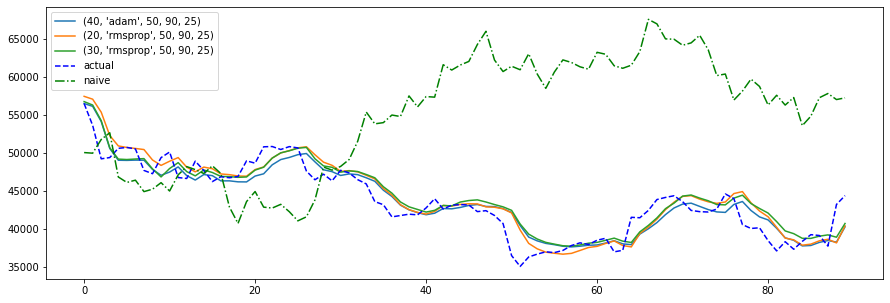

In [214]:
prediction_horizon = 90
plt.clf()    
plt.figure(figsize=(15, 5))

for y_pred, label in zip(pred, labels):
    plt.plot(range(prediction_horizon), y_pred.flatten(), label=label) # remember to inverse the transform

plt.plot(range(prediction_horizon), y_test, c='blue', label="actual", linestyle = 'dashed')
plt.plot(range(prediction_horizon), naive_prediction, c='green', label="naive",  linestyle = 'dashdot')
plt.legend(loc="upper left")
plt.show()

dict_keys(['loss', 'mse'])


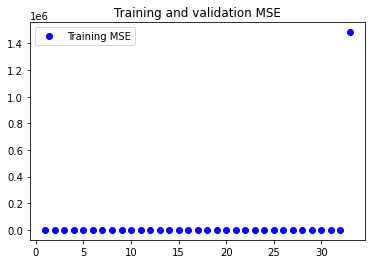

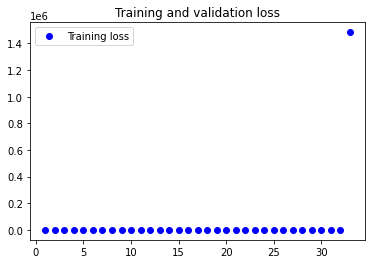

In [202]:
print(history.history.keys())
mse = history.history['mse']
#val_acc = history.history['val_accuracy']
loss = history.history['loss']
#val_loss = history.history['val_loss']
 
epochs = range(1, len(mse) + 1)
 
plt.plot(epochs, mse, 'bo', label='Training MSE')
#plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation MSE')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'bo', label='Training loss')
#plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Best hyperparameters against all models

In [206]:
# Grab best hyperparameter combination from tuning run
n_top = 0
neurons = int(output_df_sorted.iloc[n_top][0][0])
opt = str(output_df_sorted.iloc[n_top][0][1])
epochs = int(output_df_sorted.iloc[n_top][0][2])
prediction_horizon = int(output_df_sorted.iloc[n_top][0][3])
lookback_window = int(output_df_sorted.iloc[n_top][0][4])

output_df_sorted.iloc[n_top][0]

(40, 'adam', 50, 90, 25)

In [210]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Embedding, Bidirectional
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

n_features = 1 # of features in the data

# LSTM input is of the form (n_samples, lookback_window, n_features)
X_train_price = df_price['close'].values[:-prediction_horizon]
X_test_price = df_price['close'].values[-(lookback_window + prediction_horizon):]
y_test = df_price['close'].values[-prediction_horizon:]
X_train_sentiment = df_price['sentiment'].values[:-prediction_horizon].reshape(-1, 1)
X_test_sentiment = df_price['sentiment'].values[-(lookback_window + prediction_horizon):].reshape(-1, 1)

naive_prediction = df_price["close"].values[-(prediction_horizon+prediction_horizon):-prediction_horizon]

scaler = StandardScaler()
scaler.fit(X_train_price.reshape(-1, 1))
X_train_close_price = scaler.transform(X_train_price.reshape(-1, 1))
X_test_close_price = scaler.transform(X_test_price.reshape(-1, 1))
y_test = y_test.reshape(-1, 1)

X_train = hstack((X_train_close_price, X_train_sentiment))
X_test = hstack((X_test_close_price, X_test_sentiment))
Y_train = X_train_close_price

# Convert  the data from sequence to supervised data - [2, 3, 4, 5, 4, 6, 7] = [2, 3, 4] -> [5]
train_generator = TimeseriesGenerator(X_train, Y_train, length=lookback_window, batch_size=prediction_horizon)
test_generator = TimeseriesGenerator(X_test, X_test_close_price, length=lookback_window, batch_size=prediction_horizon)

list_of_models = ['build_LSTM_sentiment', 'build_LSTM_stacked_sentiment', 'build_LSTM_bidirectional_sentiment', 'build_GRU_sentiment', 'build_GRU_stacked_sentiment', 'build_GRU_bidirectional_sentiment']

output_df = {'Models': [], 'MSE':[], 'RMSE': [], 'MAPE': []}

for m in list_of_models:
    model = globals()[m](lookback_window, neurons, opt)
    history = model.fit(train_generator, epochs=epochs, verbose=0)
    prediction = model.predict(test_generator)
    y_pred = scaler.inverse_transform(prediction)

    MSE = mean_squared_error(y_test, y_pred, squared=True)
    RMSE = mean_squared_error(y_test, y_pred, squared=False)
    MAPE = Calc_MAPE(y_test, y_pred)
    output_df['Models'].append(m)
    output_df['MSE'].append(MSE)
    output_df['RMSE'].append(RMSE)
    output_df['MAPE'].append(MAPE)
    
naive_baseline_MSE = mean_squared_error(y_test, naive_prediction, squared=True)
naive_baseline_RMSE = mean_squared_error(y_test, naive_prediction, squared=False)
naive_baseline_MAPE = Calc_MAPE(y_test, y_pred)
output_df['Models'].append('naive_baseline')
output_df['MSE'].append(naive_baseline_MSE)
output_df['RMSE'].append(naive_baseline_RMSE)
output_df['MAPE'].append(naive_baseline_MAPE)

pd.DataFrame(output_df)

,Models,MSE,RMSE,MAPE
0,build_LSTM_sentiment,5.618086e+06,2370.250161,4.332274
1,build_LSTM_stacked_sentiment,1.006564e+07,3172.639348,5.881247
2,build_LSTM_bidirectional_sentiment,9.076195e+06,3012.672383,5.544754
3,build_GRU_sentiment,2.985088e+06,1727.740726,2.903595
4,build_GRU_stacked_sentiment,3.340000e+06,1827.566726,3.057440
5,build_GRU_bidirectional_sentiment,4.259321e+06,2063.812252,3.555111
6,naive_baseline,2.588805e+08,16089.763053,3.555111


In [211]:
pd.DataFrame(output_df).sort_values(['MSE'], ascending=True)

,Models,MSE,RMSE,MAPE
3,build_GRU_sentiment,2.985088e+06,1727.740726,2.903595
4,build_GRU_stacked_sentiment,3.340000e+06,1827.566726,3.057440
5,build_GRU_bidirectional_sentiment,4.259321e+06,2063.812252,3.555111
0,build_LSTM_sentiment,5.618086e+06,2370.250161,4.332274
2,build_LSTM_bidirectional_sentiment,9.076195e+06,3012.672383,5.544754
1,build_LSTM_stacked_sentiment,1.006564e+07,3172.639348,5.881247
6,naive_baseline,2.588805e+08,16089.763053,3.555111


dict_keys(['loss', 'mse'])


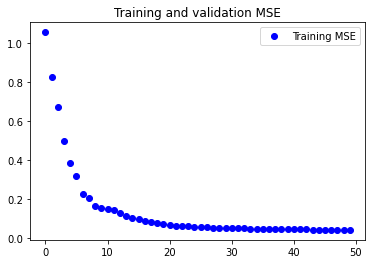

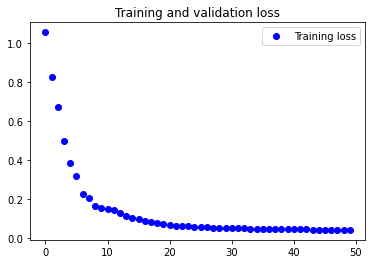

In [212]:
print(history.history.keys())
mse = history.history['mse']
#val_acc = history.history['val_accuracy']
loss = history.history['loss']
#val_loss = history.history['val_loss']
 
plt.plot(range(epochs), mse, 'bo', label='Training MSE')
#plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation MSE')
plt.legend()
 
plt.figure()
 
plt.plot(range(epochs), loss, 'bo', label='Training loss')
#plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

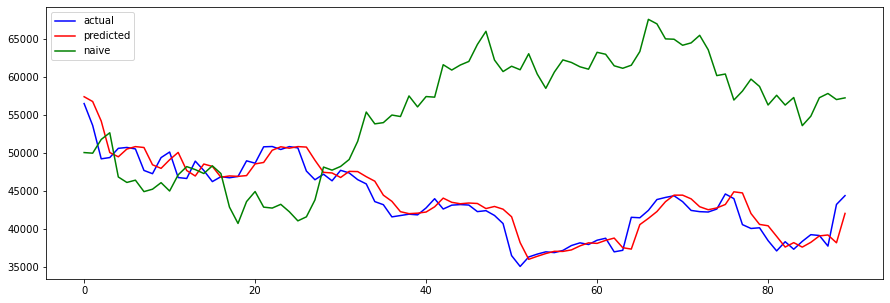

In [213]:
model = build_GRU_sentiment(lookback_window, neurons, opt)

history = model.fit(train_generator, epochs=epochs, verbose=0)
prediction = model.predict(test_generator)
y_pred = scaler.inverse_transform(prediction)
y_pred = y_pred.flatten()

plt.clf()
plt.figure(figsize=(15, 5))
plt.plot(range(prediction_horizon), y_test, c='blue', label="actual")
plt.plot(range(prediction_horizon), y_pred, c='red', label="predicted") # remember to inverse the transform
plt.plot(range(prediction_horizon), naive_prediction, c='green', label="naive")
plt.legend(loc="upper left")
plt.show()